In [12]:
# for file management
import os
import logging
from docopt import docopt

# For analysis
import numpy as np
from osgeo import gdal
import pandas as pd
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from scipy import stats
from itertools import product
from sklearn.metrics import cohen_kappa_score
# For visualization
% matplotlib inline
from matplotlib import pyplot as plt

UsageError: Line magic function `%` not found.


In [13]:
# you need to set the right directory on your own setting!!!
# Please set the diretory(path) of your raster_data, train_data, and test_data.

raster_data_path13 = "D:\\GEODATA\\Satellite\\2021-1(MEU_FINAL)\\MEU_FINAL\\L8_20130916\\L8_Seoul_20130916.tif"
raster_data_path20 = "D:\\GEODATA\\Satellite\\2021-1(MEU_FINAL)\\MEU_FINAL\\L8_20200428\\L8_Seoul_20200428.tif"
train_data_path = "D:\\GEODATA\\Satellite\\2021-1(MEU_FINAL)\\MEU_FINAL\\Data\\TRAIN-"
test_data_path = "D:\\GEODATA\\Satellite\\2021-1(MEU_FINAL)\\MEU_FINAL\\Data\\TEST-"

In [14]:
# Read raster
raster_dataset13 = gdal.Open(raster_data_path13, gdal.GA_ReadOnly)
# Get Projection system 
geo_transform = raster_dataset13.GetGeoTransform()
proj = raster_dataset13.GetProjectionRef()

# Read bands as arrays
bands_data13 = []
for b in range(1, raster_dataset13.RasterCount+1):
    band = raster_dataset13.GetRasterBand(b)
    bands_data13.append(band.ReadAsArray())

#Stack arrays together 
bands_data13 = np.dstack(bands_data13)

# Change NA values to zero
bands_data13[np.isnan(bands_data13)] = 0

# Get the shape of the image 
rows, cols, n_bands = bands_data13.shape

######################################################
# Read raster
raster_dataset20 = gdal.Open(raster_data_path20, gdal.GA_ReadOnly)
# Get Projection system 
geo_transform = raster_dataset20.GetGeoTransform()
proj = raster_dataset20.GetProjectionRef()

# Read bands as arrays
bands_data20 = []
for b in range(1, raster_dataset20.RasterCount+1):
    band = raster_dataset20.GetRasterBand(b)
    bands_data20.append(band.ReadAsArray())

#Stack arrays together 
bands_data20 = np.dstack(bands_data20)

# Change NA values to zero
bands_data20[np.isnan(bands_data20)] = 0

# Get the shape of the image 
rows, cols, n_bands = bands_data20.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<AxesSubplot:title={'center':'2020'}>,
 Text(0.5, 1.0, '2020'))

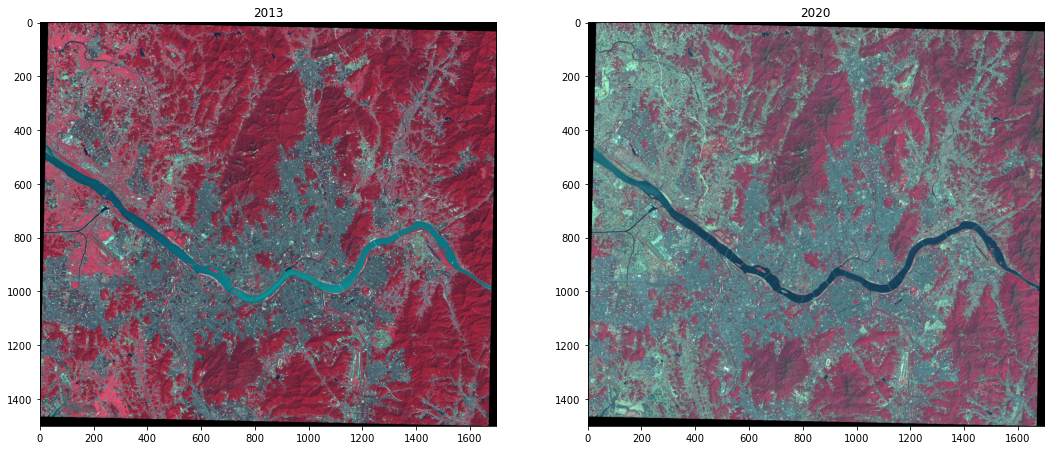

In [15]:
fig, ax = plt.subplots(1,4, figsize =(18,15))
###########################################

#####
# Select False color bands
b4_13 = bands_data13[:,:,3]
b3_13 = bands_data13[:,:,2]
b2_13 = bands_data13[:,:,1]

# Stack them
false_color13 = np.dstack([b4_13,b3_13*2,b2_13*2])

#####
# Select False color bands
b4_20 = bands_data20[:,:,3]
b3_20 = bands_data20[:,:,2]
b2_20 = bands_data20[:,:,1]

# Stack them
false_color20 = np.dstack([b4_20,b3_20*2,b2_20*2])

#Plot
#Plot
plt.subplot(121), plt.imshow(false_color13*2), plt.title("2013")
plt.subplot(122), plt.imshow(false_color20*2), plt.title("2020")

In [16]:
# Create mask
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)

    # Read each layer
    layer = data_source.GetLayer(0)

    # Get the data type
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)

    # Set the projection the same as the images
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)

    # Rasterize mask
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


# Rasterize vector
def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize the vectors in the given directory in a single image."""
    labeled_pixels = np.zeros((rows, cols))

    # Create arrays of sample data
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels

In [17]:
# Get all the files ending with .shp
train_files = [f for f in os.listdir(train_data_path) if f.endswith('.shp')]

# Get the name of shapefiles and save it as classes
training_classes = [f.split('.')[0] for f in train_files]

#Join directory path with file names
train_shpfile = [os.path.join(train_data_path, f)
              for f in train_files if f.endswith('.shp')]

# Rasterize vectors
labeled_pixels = vectors_to_raster(train_shpfile, rows, cols, geo_transform, proj)

# Return non-zero values
is_train = np.nonzero(labeled_pixels)

#Get label and sample data
training_labels = labeled_pixels[is_train]
training_samples13 = bands_data13[is_train]
training_samples20 = bands_data20[is_train]

In [18]:
label_vals=[]
sample_vals=[]
for i in np.unique(training_labels):
    label_tot = sum(training_labels==i)
    sample_tot = (sum(training_labels==i))*10
    label_vals.append(label_tot)
    sample_vals.append(sample_tot)

stats_all= [sample_vals, label_vals]


stat_summary = pd.DataFrame(data =stats_all,
            index = ['Training samples','Label/target samples'],
            columns = ['BU','FARM', 'FOREST', 'WATER'])


print("Total number of Training samples: %s points" %training_labels.size)
print("Total number of Label samples %s" %training_samples13.size)
print(" Across the three classes: ")
print("")
print(stat_summary)

Total number of Training samples: 886 points
Total number of Label samples 5316
 Across the three classes: 

                        BU  FARM  FOREST  WATER
Training samples      2650  1570    2830   1810
Label/target samples   265   157     283    181


In [19]:
# Get optimze parameters for Suppor Vector Machine Algorithms
# It may takes a minute

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

param_grid = {'C': [0.1, 1, 10, 100,1000], 'kernel': ['poly']}
classifier_13 = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
classifier_13.fit(training_samples13, training_labels)
print(classifier_13.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   0.0s
[CV] C=1, kernel=poly ................................................
[CV] ................................. C=1, kernel=poly, total=   0.0s
[CV] C=1, kernel=poly ................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................................ C=10, kernel=poly, total=   0.1s
[CV] C=10, kernel=poly ...............................................
[CV] ................................ C=10, kernel=poly, total=   0.1s
[CV] C=10, kernel=poly ...............................................
[CV] ................................ C=10, kernel=poly, total=   0.1s
[CV] C=10, kernel=poly ...............................................
[CV] ................................ C=10, kernel=poly, total=   0.1s
[CV] C=10, kernel=poly ...............................................
[CV] ................................ C=10, kernel=poly, total=   0.1s
[CV] C=100, kernel=poly ..............................................
[CV] ............................... C=100, kernel=poly, total=   1.7s
[CV] C=100, kernel=poly ..............................................
[CV] ............................... C=100, kernel=poly, total=   0.8s
[CV] C=100, kernel=poly ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   52.7s finished


SVC(C=100, kernel='poly')


In [22]:
# It may takes a minute

param_grid = {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['poly']}
classifier_20 = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
classifier_20.fit(training_samples20, training_labels)
print(classifier_20.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   0.0s
[CV] C=1, kernel=poly ................................................
[CV] ................................. C=1, kernel=poly, total=   0.1s
[CV] C=1, kernel=poly ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................................. C=1, kernel=poly, total=   0.1s
[CV] C=1, kernel=poly ................................................
[CV] ................................. C=1, kernel=poly, total=   0.1s
[CV] C=1, kernel=poly ................................................
[CV] ................................. C=1, kernel=poly, total=   0.1s
[CV] C=1, kernel=poly ................................................
[CV] ................................. C=1, kernel=poly, total=   0.1s
[CV] C=10, kernel=poly ...............................................
[CV] ................................ C=10, kernel=poly, total=   0.5s
[CV] C=10, kernel=poly ...............................................
[CV] ................................ C=10, kernel=poly, total=   0.3s
[CV] C=10, kernel=poly ...............................................
[CV] ................................ C=10, kernel=poly, total=   0.5s
[CV] C=10, kernel=poly ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.9min finished


SVC(C=100, kernel='poly')


In [21]:
#Train the classifier the optimized parameters
classifier_poly_svm13 = svm.SVC(C=1000, gamma='scale', kernel = 'poly')

# Fit the classifier
classifier_poly_svm13 = classifier_poly_svm13.fit(training_samples13, training_labels)
classifier_poly_svm13

SVC(C=1000, kernel='poly')

In [23]:
#Train the classifier the optimized parameters
classifier_poly_svm20 =svm.SVC(C=1000, gamma='scale', kernel = 'poly')

# Fit the classifier
classifier_poly_svm20 = classifier_poly_svm20.fit(training_samples20, training_labels)
classifier_poly_svm20

SVC(C=1000, kernel='poly')

In [24]:
# Grab the dimension
n_samples = rows*cols

# Reshape images dimension
flat_pixels13 = bands_data13.reshape((n_samples, n_bands))
flat_pixels20 = bands_data20.reshape((n_samples, n_bands))

# Predict
result_13 = classifier_poly_svm13.predict(flat_pixels13)
result_20 = classifier_poly_svm20.predict(flat_pixels20)


# Get the rows and columns
classification_2013 = result_13.reshape((rows, cols))
classification_2020 = result_20.reshape((rows, cols))

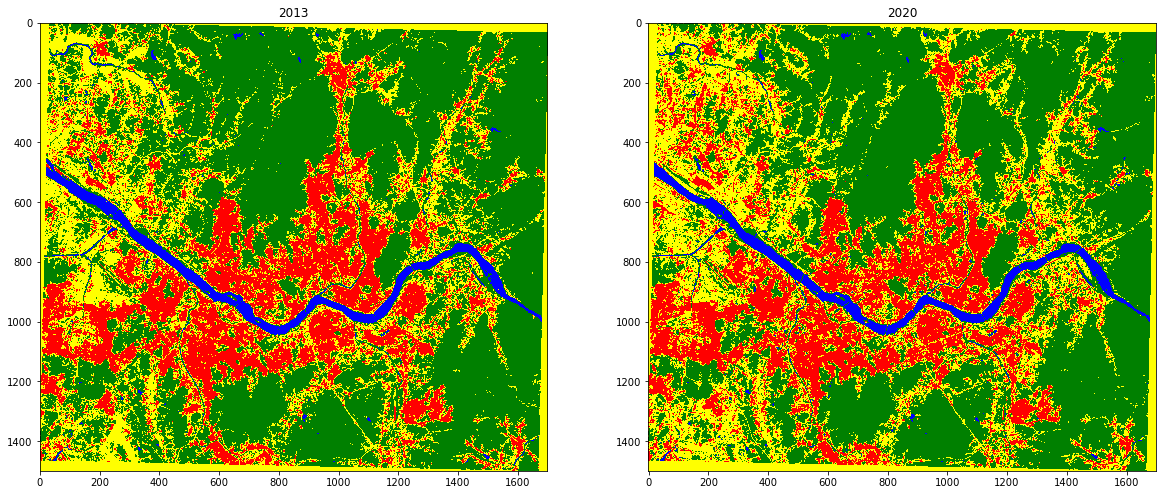

In [25]:
# Get the calssification visualization
# it may takes a minute

fig, ax = plt.subplots(1,2, figsize =(20,16))

colors = ['red', 'yellow', 'green', 'blue']
cmap = matplotlib.colors.ListedColormap(colors)
plt.subplot(121), plt.imshow(classification_2013, cmap = cmap),plt.title("2013")
plt.subplot(122), plt.imshow(classification_2020, cmap = cmap),plt.title("2020")
plt.show()

In [26]:
test_files  = [f for f in os.listdir(test_data_path) if f.endswith('.shp')]

# Get the name of shapefiles and save it as classes
testing_classes = [f.split('.')[0] for f in test_files]


# Get the test shapefile data
test_shpfile = [os.path.join(test_data_path, "%s.shp" % c)
              for c in testing_classes]

# Rasterize shapefiles
test_pixels = vectors_to_raster(test_shpfile, rows, cols,
                                        geo_transform, proj)

#Create non-zero images
test_image = np.nonzero(test_pixels)


#Get test outputs and labels
testing_labels = test_pixels[test_image]
testing_labels13 = classification_2013[test_image]
testing_labels20 = classification_2020[test_image]

In [107]:
# Overall accuracy of classification result of 2013 satellite image.

target_names = ['Class %s' % s for s in testing_classes]
print("Classification report:\n%s" %
      metrics.classification_report(testing_labels, testing_labels13,
                                    target_names=target_names))
print("Overall accuracy: %f" %
      metrics.accuracy_score(testing_labels, testing_labels13))

print ("Kappa Statistics: %f " %
       cohen_kappa_score(testing_labels, testing_labels13))

Classification report:
                   precision    recall  f1-score   support

    Class BU_TEST       0.82      0.91      0.86        55
  Class FARM_TEST       0.90      0.67      0.77        52
Class FOREST_TEST       0.81      0.92      0.86        65
 Class WATER_TEST       1.00      0.97      0.99        77

         accuracy                           0.88       249
        macro avg       0.88      0.87      0.87       249
     weighted avg       0.89      0.88      0.88       249

Overall accuracy: 0.883534
Kappa Statistics: 0.843134 


In [27]:
# Overall accuracy of classification result of 2020 satellite image.

target_names = ['Class %s' % s for s in testing_classes]
print("Classification report:\n%s" %
      metrics.classification_report(testing_labels, testing_labels20,
                                    target_names=target_names))
print("Overall accuracy: %f" %
      metrics.accuracy_score(testing_labels, testing_labels20))
print ("Kappa Statistics: %f " %
       cohen_kappa_score(testing_labels, testing_labels20))

Classification report:
                   precision    recall  f1-score   support

    Class BU_TEST       0.94      0.93      0.94        55
  Class FARM_TEST       0.85      0.67      0.75        52
Class FOREST_TEST       0.77      0.92      0.84        65
 Class WATER_TEST       0.97      0.96      0.97        77

         accuracy                           0.88       249
        macro avg       0.89      0.87      0.87       249
     weighted avg       0.89      0.88      0.88       249

Overall accuracy: 0.883534
Kappa Statistics: 0.842943 


In [28]:
# Change each image to an integer array type
arr1 = np.array(classification_2013, dtype = int)
arr2 = np.array(classification_2020, dtype = int)

# Iterate to check for change
lookup = np.array(((0, 2, 3, 4),
                   (1, 0, 3, 4),
                   (1, 2, 0, 4),
                   (1, 2, 3, 0)), dtype=int)

detection_layer = np.zeros_like(arr1)

for r, c in product(*[range(x) for x in arr1.shape]):
    a, b = arr1[r,c], arr2[r,c]
    detection_layer[r,c] = lookup[a-1,b-1]

In [29]:
# Detecting Changes of land cover between 2013 and 2020

change_unique = np.unique(detection_layer)
class_change = []

# Count Pixels
for group in change_unique:
    class_change.append(len(detection_layer[detection_layer == group]))

# Change Pixels to Sq.Km
class_size = []
for i in class_change:
    area = i *0.001
    area_arr = np.array(area).round(2)
    class_size.append(area_arr)


print("%r pixels or %r Km.Sq area showed no change "  %(class_change[0], class_size[0]))
print("%r pixels %r Km.Sq changed to Builtup area" %(class_change[1],  class_size[1]))
print("%r pixels %r Km.Sq changed to Farm & Barren" %(class_change[2], class_size[2]))
print("%r pixels %r Km.Sq changed to Vegetation" %(class_change[3], class_size[3]))
print("%r pixels %r Km.Sq changed to Water" %(class_change[4], class_size[4]))

2018523 pixels or 2018.52 Km.Sq area showed no change 
124674 pixels 124.67 Km.Sq changed to Builtup area
216056 pixels 216.06 Km.Sq changed to Farm & Barren
147094 pixels 147.09 Km.Sq changed to Vegetation
40653 pixels 40.65 Km.Sq changed to Water


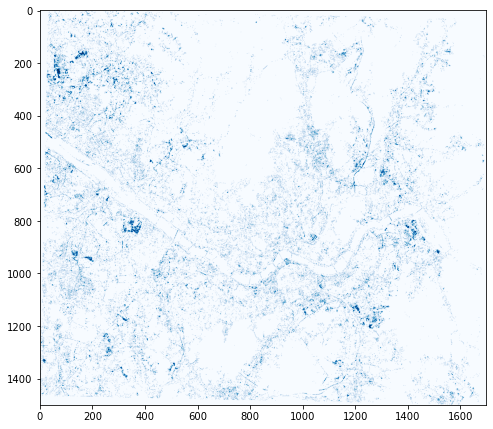

In [30]:
# Images of changed built-up area in 2020

fig = plt.subplots( figsize =(8,8))
plt.imshow(detection_layer==1, cmap="Blues" )
plt.show()